# Final Model


based on model 5 in the modeling notebook

In [59]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, SCORERS
from sklearn.ensemble import RandomForestRegressor


from xgboost import XGBRegressor

from yellowbrick.regressor import ResidualsPlot

sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'text.color': '0.5', 'axes.labelcolor': '1', 'xtick.color': '1', 'ytick.color': '1'})

In [29]:
rs = 123

## Data wrangling

### Import data

In [30]:
# import necessary data
df_data = pd.read_csv('../data/train_wide_with_hours.csv')
df_daily_means = pd.read_csv('../data/train_daily_mean.csv')

### Feature engineering

In [31]:
features = df_daily_means.columns[2:]
df_daily_means = df_daily_means.pivot(index='ID', values=features, columns='day').reset_index()
df_daily_means = df_daily_means.drop('ID', axis=1, level=0)

In [32]:
df_data = pd.concat([df_data, df_daily_means], axis=1)
df_data

,ID,location,target,max_temp,min_temp,mean_temp,std_temp,var_temp,median_temp,ptp_temp,...,"(wind_spd, 1.0)","(wind_spd, 2.0)","(wind_spd, 3.0)","(wind_spd, 4.0)","(wind_spd, 5.0)","(atmos_press, 1.0)","(atmos_press, 2.0)","(atmos_press, 3.0)","(atmos_press, 4.0)","(atmos_press, 5.0)"
0,ID_train_0,C,45.126304,27.208333,19.275000,22.299527,2.594011,6.728895,21.358333,7.933333,...,NaN,NaN,NaN,NaN,0.677348,NaN,NaN,NaN,NaN,87.752434
1,ID_train_1,D,79.131702,33.616667,17.983333,24.679063,4.266955,18.206903,23.791667,15.633333,...,0.786433,1.014201,0.805000,1.015694,0.879410,90.360500,90.380660,90.441806,90.429653,90.539896
2,ID_train_10,A,32.661304,31.841667,18.458333,24.112317,3.776377,14.261020,23.304167,13.383333,...,NaN,1.167222,0.948542,1.130590,1.020764,88.584967,88.488696,88.353993,88.376979,88.296007
3,ID_train_100,A,53.850238,27.491667,16.941667,20.845273,3.080140,9.487259,19.541667,10.550000,...,1.423250,1.354514,2.006563,1.961875,1.038472,88.401000,88.254583,88.356076,88.488229,88.383681
4,ID_train_1000,A,177.418750,28.750000,17.525000,21.870732,3.286870,10.803515,20.950000,11.225000,...,0.762800,0.521111,0.629773,NaN,NaN,88.541633,88.546389,88.481553,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15534,ID_train_9995,A,44.850286,27.841667,16.550000,20.573209,2.987662,8.926124,19.458333,11.291667,...,1.143125,0.981726,1.336429,0.915312,0.752396,88.347367,88.222604,88.321632,88.500868,88.523681
15535,ID_train_9996,E,24.330455,29.550000,18.991667,23.546832,2.614979,6.838117,23.208333,10.558333,...,1.315900,1.199201,0.981157,1.257986,1.046146,88.488733,88.519132,88.410382,88.371840,88.386910
15536,ID_train_9997,D,38.972128,34.108333,16.950000,24.637083,4.352597,18.945097,24.179167,17.158333,...,0.856533,0.943646,1.035069,1.046111,1.249896,90.570233,90.627639,90.537951,90.422187,90.451979
15537,ID_train_9998,D,41.720952,30.900000,15.891667,23.472934,4.651403,21.635547,23.066667,15.008333,...,0.869767,1.258021,1.152535,0.709047,0.771269,90.445100,90.447361,90.512014,90.520956,90.507292


### Split data into features and target

In [33]:
# get target
y = np.log10(df_data['target']+1)
# get features
X = df_data.iloc[:, 52:] #np.log10(df_train.iloc[:, 52:]+1)
# extract locations and encode
loc_dummies = pd.get_dummies(df_data['location'], drop_first=True)
# add to feature matrix
X = pd.concat([X, loc_dummies], axis=1)

In [34]:
X

,newtemp0,newprecip0,newrel_humidity0,newwind_dir0,windspeed0,atmospherepressure0,hour0,newtemp1,newprecip1,newrel_humidity1,...,"(wind_spd, 5.0)","(atmos_press, 1.0)","(atmos_press, 2.0)","(atmos_press, 3.0)","(atmos_press, 4.0)","(atmos_press, 5.0)",B,C,D,E
0,26.909091,0.000,0.510818,272.902752,0.800909,87.777273,1.0,27.208333,0.000,0.535417,...,0.677348,NaN,NaN,NaN,NaN,87.752434,0,1,0,0
1,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,1.0,21.716667,0.000,0.808083,...,0.879410,90.360500,90.380660,90.441806,90.429653,90.539896,0,0,1,0
2,28.975000,0.000,0.573333,328.682914,1.032500,88.551667,1.0,27.950000,0.000,0.597167,...,1.020764,88.584967,88.488696,88.353993,88.376979,88.296007,0,0,0,0
3,22.966667,0.000,0.843083,300.085057,1.446667,88.615000,1.0,24.266667,0.000,0.790250,...,1.038472,88.401000,88.254583,88.356076,88.488229,88.383681,0,0,0,0
4,21.875000,0.000,0.856417,21.839974,0.197500,88.556667,1.0,21.575000,0.000,0.874917,...,NaN,88.541633,88.546389,88.481553,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15534,22.716667,31.467,0.794091,175.071529,0.978333,88.276667,1.0,16.933333,31.842,0.974250,...,0.752396,88.347367,88.222604,88.321632,88.500868,88.523681,0,0,0,0
15535,25.375000,0.000,0.685333,176.543826,1.328333,88.436667,1.0,26.025000,0.000,0.654917,...,1.046146,88.488733,88.519132,88.410382,88.371840,88.386910,0,0,0,1
15536,26.091667,0.000,0.781750,121.706016,0.936667,90.615833,1.0,28.975000,0.000,0.578083,...,1.249896,90.570233,90.627639,90.537951,90.422187,90.451979,0,0,1,0
15537,29.225000,0.000,0.628333,156.475731,1.330833,90.314167,1.0,30.000000,0.000,0.605833,...,0.771269,90.445100,90.447361,90.512014,90.520956,90.507292,0,0,1,0


### Generate Train/Test sets

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rs)

## Base model

### Train base model

In [36]:
xgb_base = XGBRegressor()
xgb_base.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [37]:
y_pred = xgb_base.predict(X_test)
y_train_pred = xgb_base.predict(X_train)

### Evaluate base model

In [38]:
xgb_base.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

TRAIN: RMSLE with log(features) & log(target): 0.02537773594316786
TRAIN: RMSE with log(features) & log(target):  12.360977952493213
TEST:  RMSLE with log(features) & log(target): 0.06488672739344391
TEST:  RMSE with log(features) & log(target):  28.77078268283199


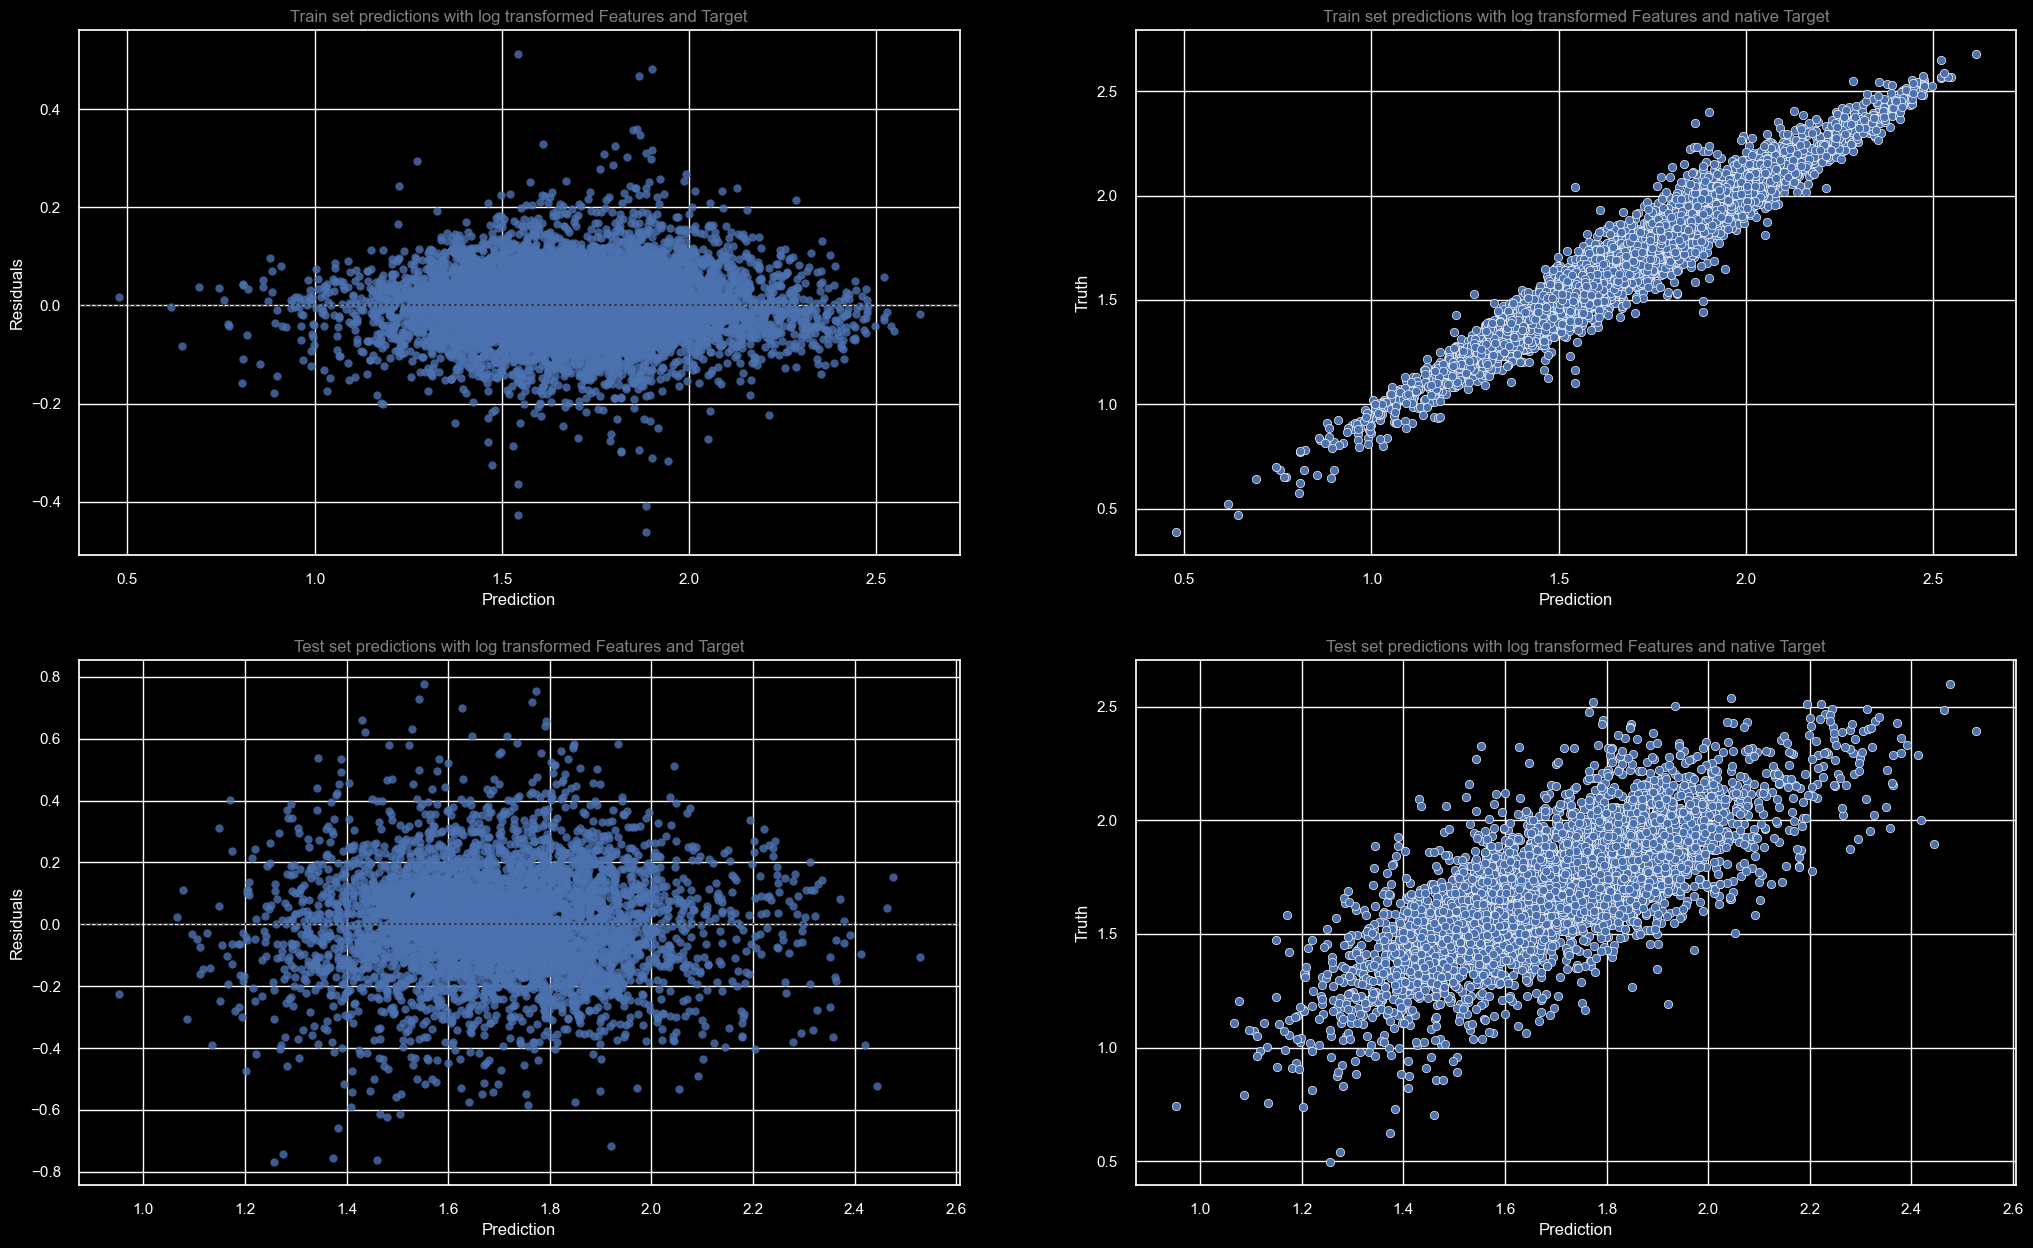

In [39]:
# print RMSE and RMSLE
print(f"TRAIN: RMSLE with log(features) & log(target): {mean_squared_log_error(y_train, y_train_pred, squared=False)}")
print(f"TRAIN: RMSE with log(features) & log(target):  {mean_squared_error(y_true=np.power(10, y_train), y_pred=np.power(10, y_train_pred), squared=False)}")
print(f"TEST:  RMSLE with log(features) & log(target): {mean_squared_log_error(y_test, y_pred, squared=False)}")
print(f"TEST:  RMSE with log(features) & log(target):  {mean_squared_error(y_true=np.power(10, y_test), y_pred=np.power(10, y_pred), squared=False)}")

# plot residual distribution
fig, ax = plt.subplots(2, 2, figsize=(25, 15))

g1 = sns.residplot(x=y_train_pred, y=y_train, ax=ax[0][0])
g2 = sns.scatterplot(x=y_train_pred, y=y_train, ax=ax[0][1])
g3 = sns.residplot(x=y_pred, y=y_test, ax=ax[1][0])
g4 = sns.scatterplot(x=y_pred, y=y_test, ax=ax[1][1])

g1.set_title('Train set predictions with log transformed Features and Target')
g2.set_title('Train set predictions with log transformed Features and native Target')
g3.set_title('Test set predictions with log transformed Features and Target')
g4.set_title('Test set predictions with log transformed Features and native Target')

g1.set_ylabel('Residuals')
g1.set_xlabel('Prediction')
g2.set_ylabel('Truth')
g2.set_xlabel('Prediction')
g3.set_ylabel('Residuals')
g3.set_xlabel('Prediction')
g4.set_ylabel('Truth')
g4.set_xlabel('Prediction');

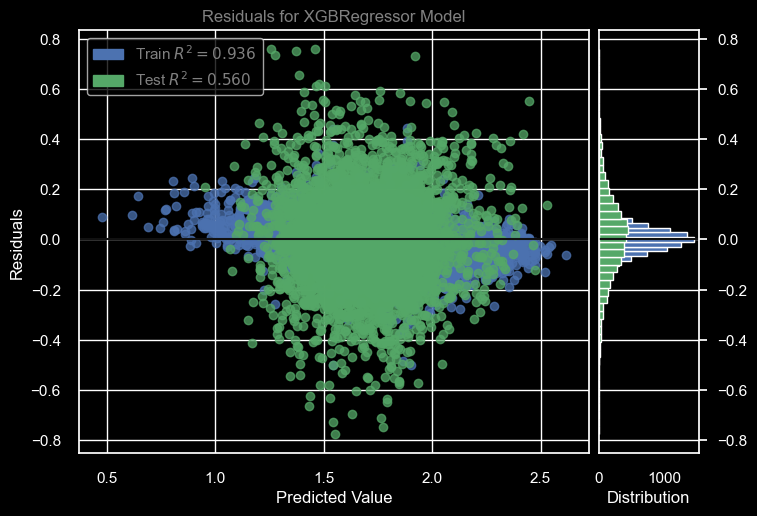

In [40]:
visualizer = ResidualsPlot(xgb_base, hist=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

## Tune Base model

In [72]:
params_xgb = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.3, 0.7],
    'n_estimators': [30, 100],
    'colsample_bytree': [0.1, 0.5, 0.75],
    'subsample': [0.6, 1],
    'max_depth': [1, 6, 10],
    'subsample': [0.1, 0.5, 1]
}

params_rf = {
    'max_features': [None, '0.5', 'sqrt'],
    'n_estimators': [30, 100],
    'min_samples_leaf': [50, 100, 1000],
    'min_samples_split': [2, 5, 10],
    'max_depth': [None, 10, 50, 100],

}

model = XGBRegressor(seed=rs)
# model = RandomForestRegressor(random_state=rs)

gscv = GridSearchCV(estimator=model, param_grid=params_xgb, scoring='neg_mean_squared_log_error', n_jobs=-1)
rscv = RandomizedSearchCV(estimator=model, param_distributions=params_xgb, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1, n_iter=10, random_state=rs)

In [73]:
# gscv.fit(X_train, y_train)
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.75, learning_rate=0.7, max_depth=1, n_estimators=30, subsample=0.1; total time=   2.5s
[CV] END colsample_bytree=0.75, learning_rate=0.7, max_depth=1, n_estimators=30, subsample=0.1; total time=   2.6s
[CV] END colsample_bytree=0.75, learning_rate=0.7, max_depth=1, n_estimators=30, subsample=0.1; total time=   2.5s
[CV] END colsample_bytree=0.75, learning_rate=0.7, max_depth=1, n_estimators=30, subsample=0.1; total time=   2.7s
[CV] END colsample_bytree=0.75, learning_rate=0.7, max_depth=1, n_estimators=30, subsample=0.1; total time=   2.6s
[CV] END colsample_bytree=0.75, learning_rate=0.3, max_depth=1, n_estimators=30, subsample=0.5; total time=   5.2s
[CV] END colsample_bytree=0.75, learning_rate=0.3, max_depth=1, n_estimators=30, subsample=0.5; total time=   5.2s
[CV] END colsample_bytree=0.75, learning_rate=0.3, max_depth=1, n_estimators=30, subsample=0.5; total time=   5.3s
[CV] END colsample_

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          min_child_weight=None, missing=nan,
                             

In [74]:
final_model = rscv.best_estimator_
final_model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 123,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'seed': 123}

In [75]:
y_pred = final_model.predict(X_test)
y_train_pred = final_model.predict(X_train)

TRAIN: RMSLE with log(features) & log(target): 0.04273976564677457
TRAIN: RMSE with log(features) & log(target):  20.6166327880754
TEST:  RMSLE with log(features) & log(target): 0.06402965547931917
TEST:  RMSE with log(features) & log(target):  28.487843643920442


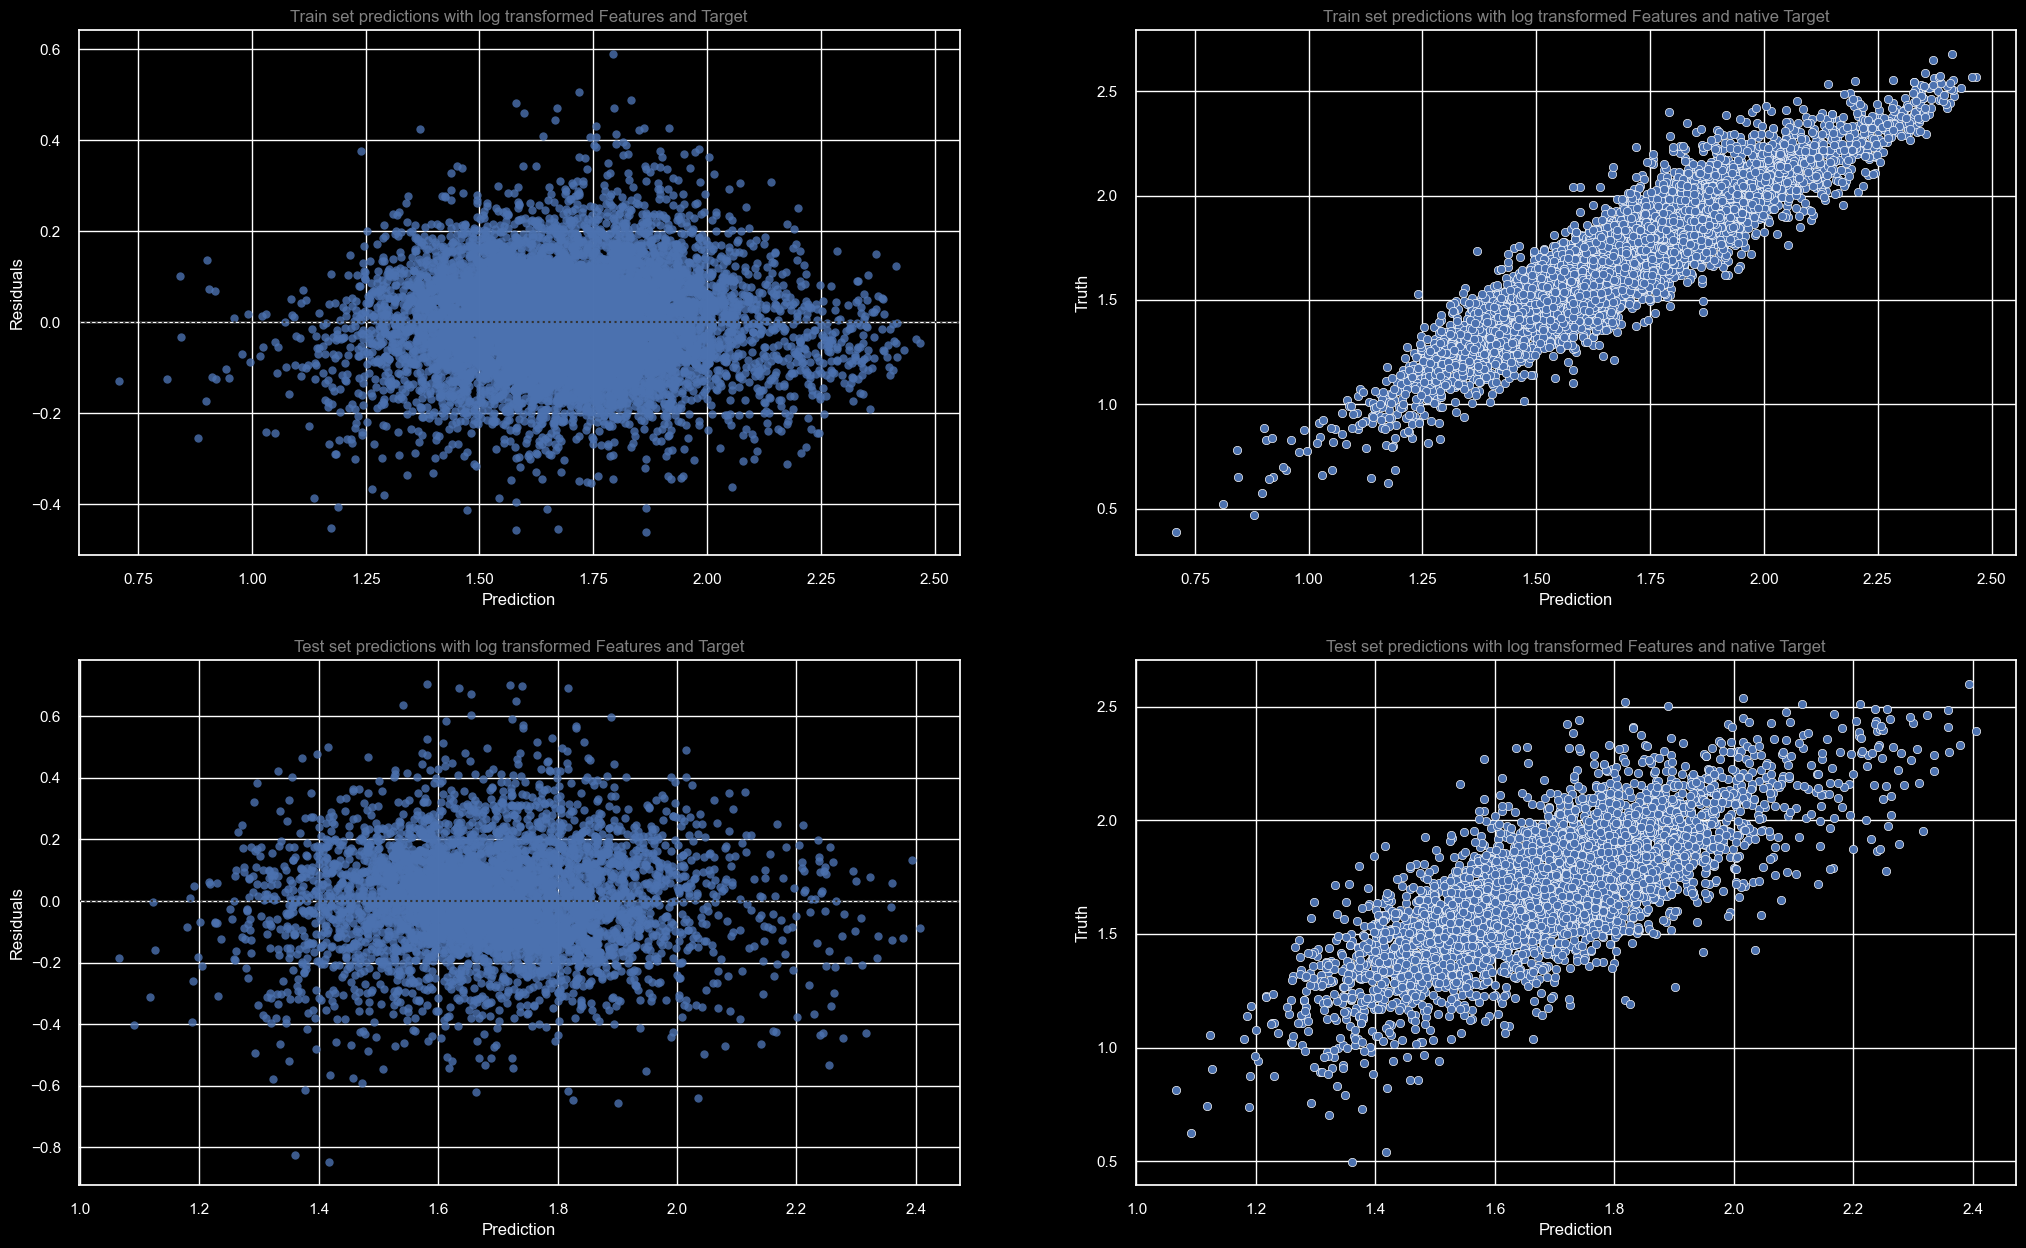

In [76]:
# print RMSE and RMSLE
print(f"TRAIN: RMSLE with log(features) & log(target): {mean_squared_log_error(y_train, y_train_pred, squared=False)}")
print(f"TRAIN: RMSE with log(features) & log(target):  {mean_squared_error(y_true=np.power(10, y_train), y_pred=np.power(10, y_train_pred), squared=False)}")
print(f"TEST:  RMSLE with log(features) & log(target): {mean_squared_log_error(y_test, y_pred, squared=False)}")
print(f"TEST:  RMSE with log(features) & log(target):  {mean_squared_error(y_true=np.power(10, y_test), y_pred=np.power(10, y_pred), squared=False)}")

# plot residual distribution
fig, ax = plt.subplots(2, 2, figsize=(25, 15))

g1 = sns.residplot(x=y_train_pred, y=y_train, ax=ax[0][0])
g2 = sns.scatterplot(x=y_train_pred, y=y_train, ax=ax[0][1])
g3 = sns.residplot(x=y_pred, y=y_test, ax=ax[1][0])
g4 = sns.scatterplot(x=y_pred, y=y_test, ax=ax[1][1])

g1.set_title('Train set predictions with log transformed Features and Target')
g2.set_title('Train set predictions with log transformed Features and native Target')
g3.set_title('Test set predictions with log transformed Features and Target')
g4.set_title('Test set predictions with log transformed Features and native Target')

g1.set_ylabel('Residuals')
g1.set_xlabel('Prediction')
g2.set_ylabel('Truth')
g2.set_xlabel('Prediction')
g3.set_ylabel('Residuals')
g3.set_xlabel('Prediction')
g4.set_ylabel('Truth')
g4.set_xlabel('Prediction');

In [77]:
with open(f'../models/model_final_2.p', 'wb') as f:
    pickle.dump(final_model, f)

## Load model and predict

In [78]:
with open('../models/model_final_2.p', 'rb') as f:
    model = pickle.load(f)

In [79]:
y_train_pred_final = model.predict(X_train)
y_test_pred_final = model.predict(X_test)

TRAIN: RMSLE with log(features) & log(target): 0.04273976564677457
TRAIN: RMSE with log(features) & log(target):  20.6166327880754
TEST:  RMSLE with log(features) & log(target): 0.06402965547931917
TEST:  RMSE with log(features) & log(target):  28.487843643920442


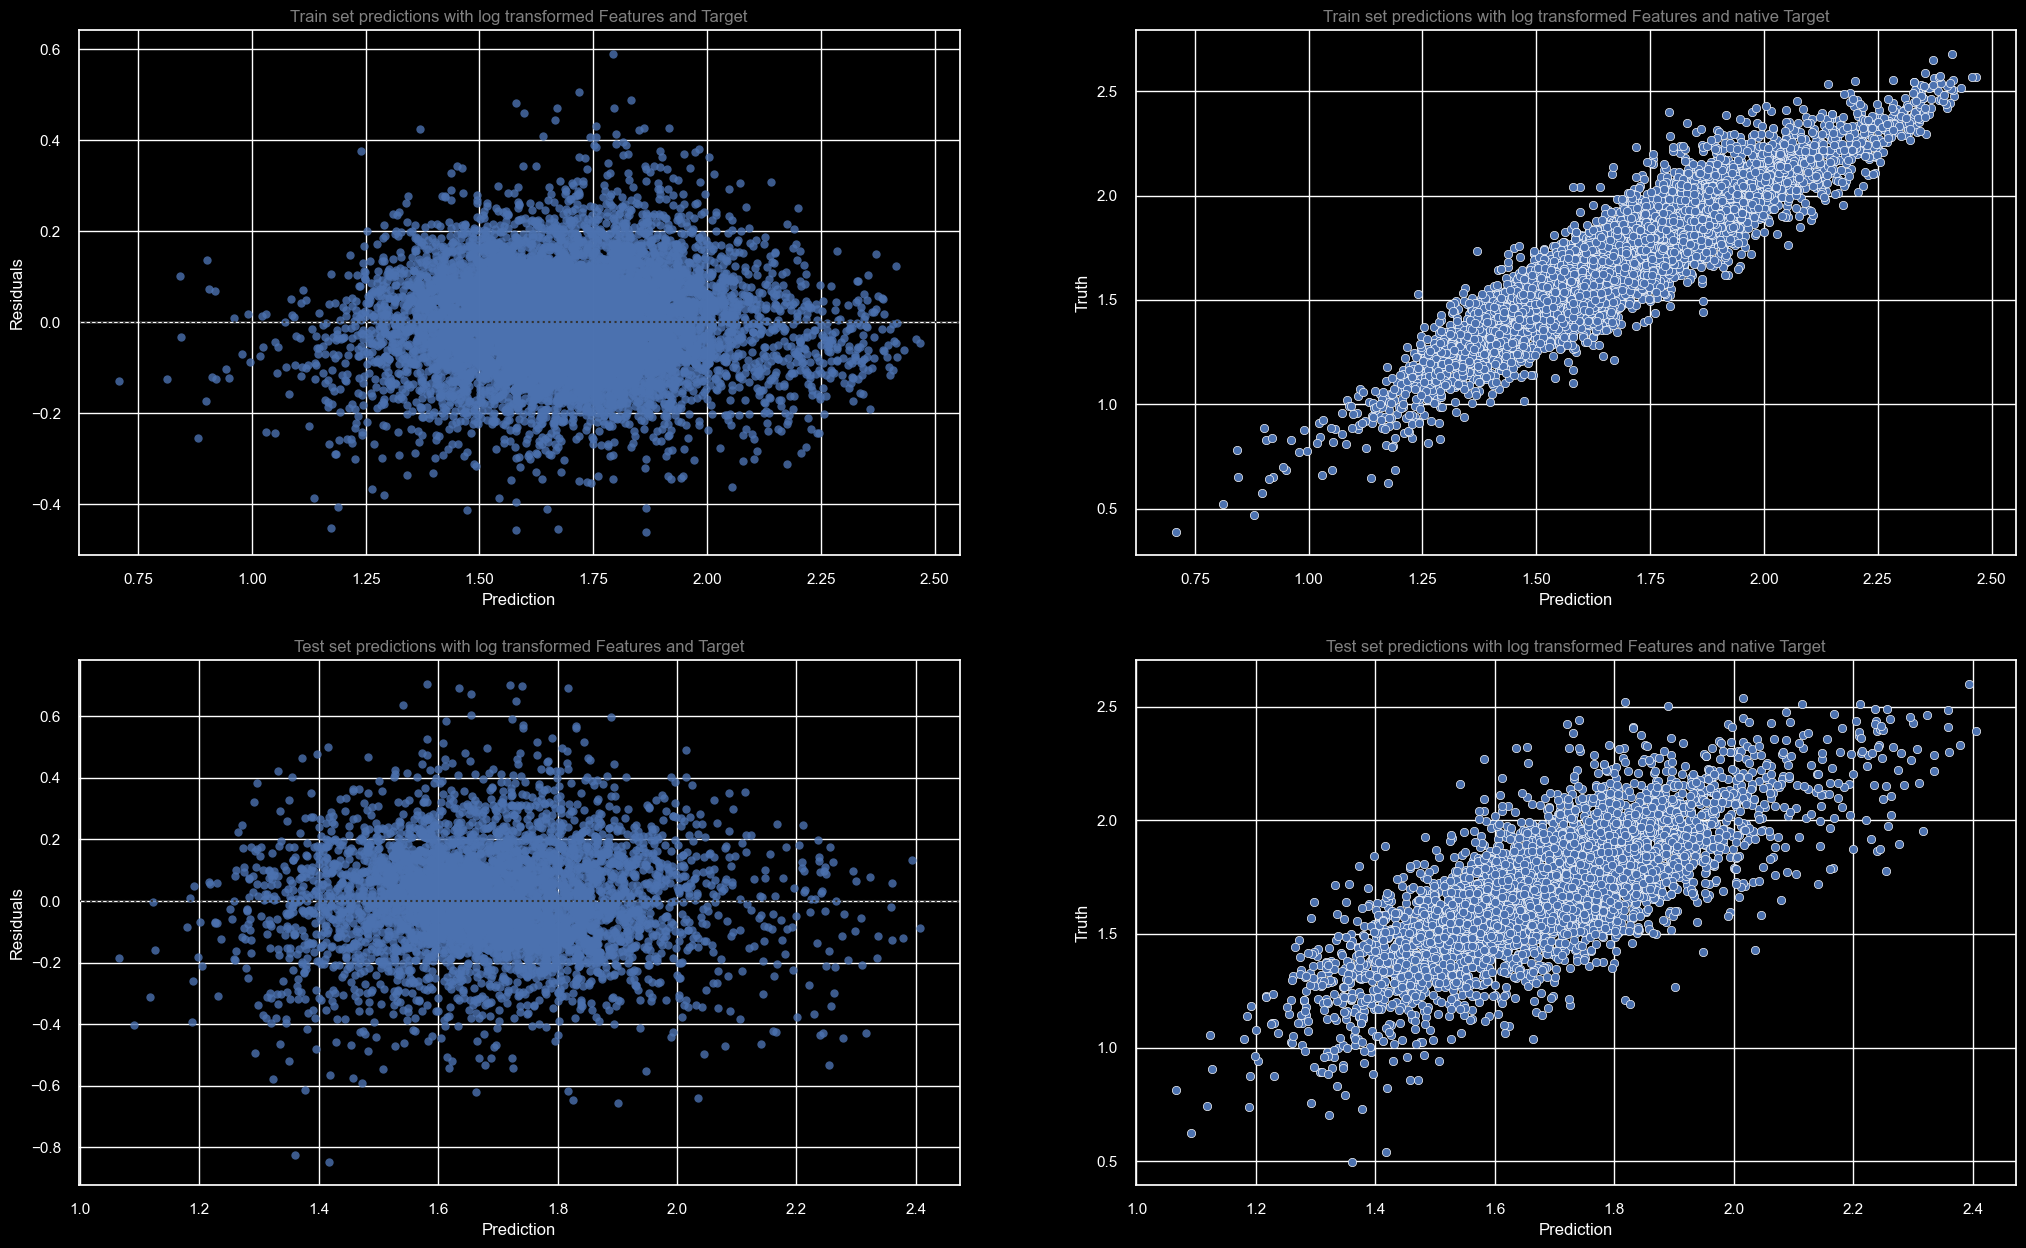

In [80]:
# print RMSE and RMSLE
print(f"TRAIN: RMSLE with log(features) & log(target): {mean_squared_log_error(y_train, y_train_pred_final, squared=False)}")
print(f"TRAIN: RMSE with log(features) & log(target):  {mean_squared_error(y_true=np.power(10, y_train), y_pred=np.power(10, y_train_pred_final), squared=False)}")
print(f"TEST:  RMSLE with log(features) & log(target): {mean_squared_log_error(y_test, y_test_pred_final, squared=False)}")
print(f"TEST:  RMSE with log(features) & log(target):  {mean_squared_error(y_true=np.power(10, y_test), y_pred=np.power(10, y_test_pred_final), squared=False)}")

# plot residual distribution
fig, ax = plt.subplots(2, 2, figsize=(25, 15))

g1 = sns.residplot(x=y_train_pred_final, y=y_train, ax=ax[0][0])
g2 = sns.scatterplot(x=y_train_pred_final, y=y_train, ax=ax[0][1])
g3 = sns.residplot(x=y_test_pred_final, y=y_test, ax=ax[1][0])
g4 = sns.scatterplot(x=y_test_pred_final, y=y_test, ax=ax[1][1])

g1.set_title('Train set predictions with log transformed Features and Target')
g2.set_title('Train set predictions with log transformed Features and native Target')
g3.set_title('Test set predictions with log transformed Features and Target')
g4.set_title('Test set predictions with log transformed Features and native Target')

g1.set_ylabel('Residuals')
g1.set_xlabel('Prediction')
g2.set_ylabel('Truth')
g2.set_xlabel('Prediction')
g3.set_ylabel('Residuals')
g3.set_xlabel('Prediction')
g4.set_ylabel('Truth')
g4.set_xlabel('Prediction');

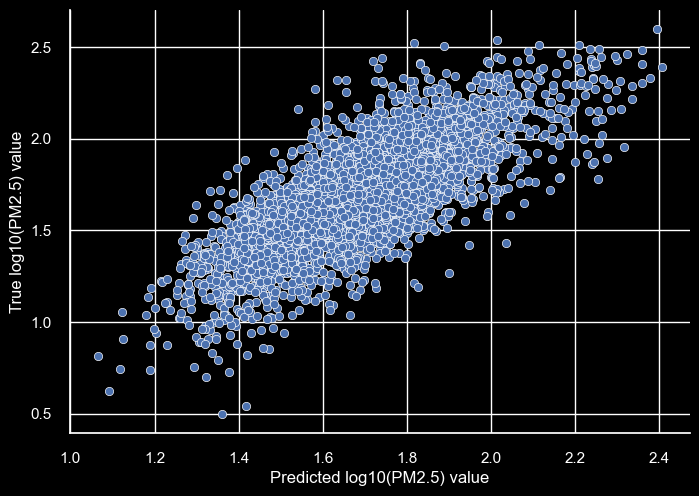

In [81]:
g4 = sns.scatterplot(x=y_test_pred_final, y=y_test)
g4.set_ylabel('True log10(PM2.5) value')
g4.set_xlabel('Predicted log10(PM2.5) value');
sns.despine()

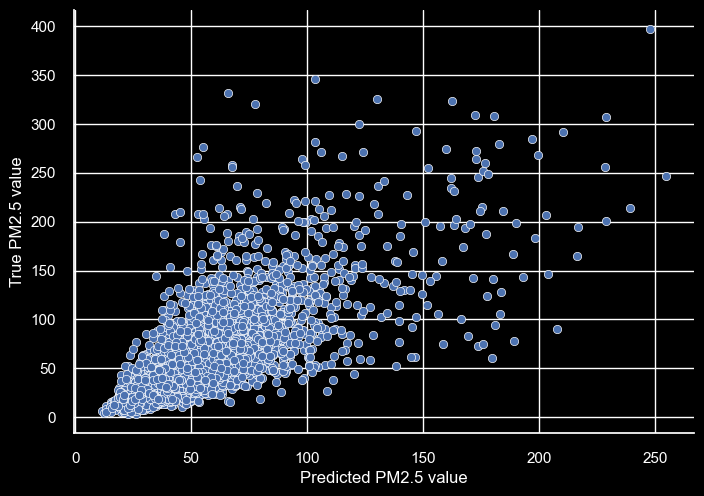

In [82]:
g4 = sns.scatterplot(x=np.power(10, y_test_pred_final), y=np.power(10, y_test))
g4.set_ylabel('True PM2.5 value')
g4.set_xlabel('Predicted PM2.5 value');

sns.despine()

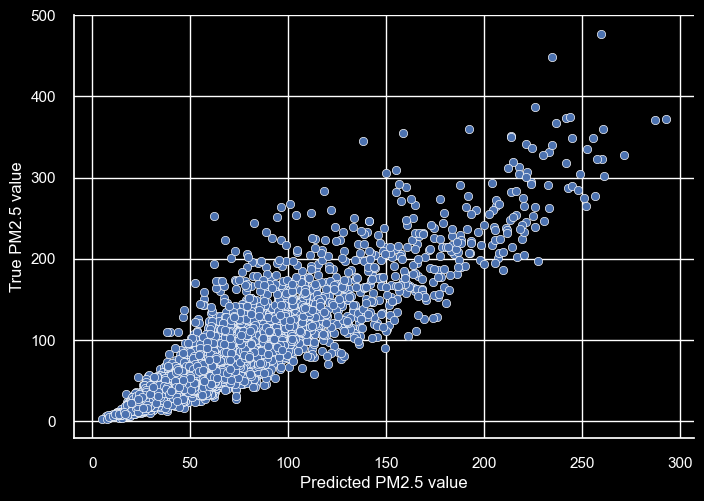

In [83]:
g4 = sns.scatterplot(x=np.power(10, y_train_pred_final), y=np.power(10, y_train))
g4.set_ylabel('True PM2.5 value')
g4.set_xlabel('Predicted PM2.5 value');

sns.despine()

In [84]:
feat_imp = list(zip(X.columns, model.feature_importances_))
pd.DataFrame(feat_imp).sort_values(by=1, ascending=False)

,0,1
880,E,0.054327
439,atmospherepressure62,0.040531
145,atmospherepressure20,0.038910
152,atmospherepressure21,0.032175
656,atmospherepressure93,0.019830
...,...,...
643,hour91,0.000000
197,newprecip28,0.000000
195,hour27,0.000000
650,hour92,0.000000


In [85]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 123,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'seed': 123}

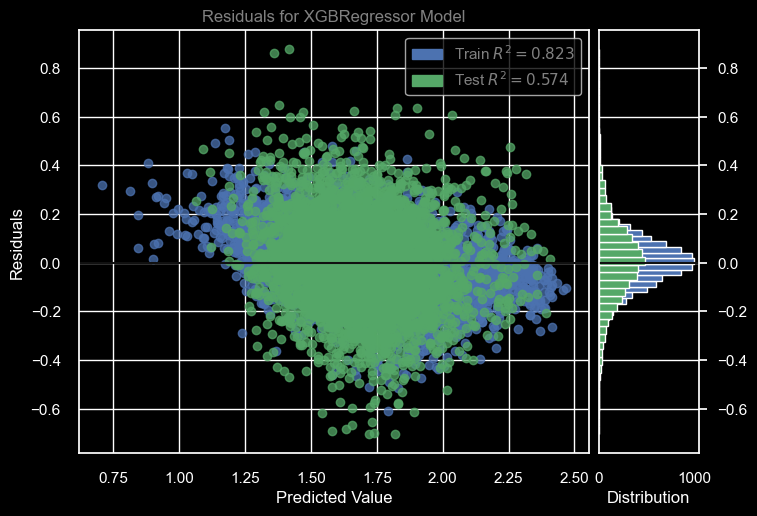

In [86]:
visualizer = ResidualsPlot(model, hist=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();